In [5]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract
import os
from PIL import Image
from pytesseract import Output
from matplotlib import pyplot as plt


In [3]:
img_location = "./data/images_data/1001(2023-06-07T08_06_44).jpg"

In [59]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe' # Change to os.path in the future
img = cv2.imread(img_location)

In [61]:
box_id = img_location.split("/")[-1].split("(")[0]
print(img_location)
print(box_id)

./data/images_data/1001(2023-06-07T08_06_44).jpg
1001


In [62]:
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

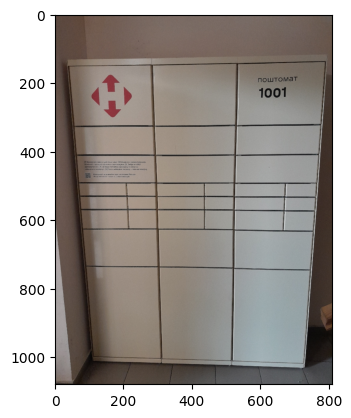

In [63]:
plt.imshow(rgb)
plt.show()

In [66]:
t = pytesseract.image_to_string(img, config="outputbase digits")

In [68]:
print(t)

In [44]:
results = pytesseract.image_to_data(rgb, output_type=Output.DICT)

In [74]:
for i in range(0, len(results["text"])):
	# extract the bounding box coordinates of the text region from
	# the current result
	x = results["left"][i]
	y = results["top"][i]
	w = results["width"][i]
	h = results["height"][i]
	# extract the OCR text itself along with the confidence of the
	# text localization
	text = results["text"][i]
	conf = int(results["conf"][i])
	print(text)





is

ic

=

ie)

e

a

fe)

=



 






In [41]:
data = pytesseract.image_to_data(img, output_type='dict')
boxes = len(data['level'])

for i in range(boxes):
    if data['text'][i] == box_id:
        print(data['left'][i], data['top'][i], data['width'][i], data['height'][i], data['text'][i])

In [73]:
def detect_number_location(image_path):
    image = cv2.imread(img_location)
    text = pytesseract.image_to_string(image, config='--psm 8')
    boxes = pytesseract.image_to_boxes(image, config='--psm 8')
    for box in boxes.splitlines():
        b = box.split()
        x, y, w, h = int(b[1]), int(b[2]), int(b[3]), int(b[4])
        print(x,y,w,h)

    return text

detected_text = detect_number_location(img_location)
print("Detected Text:", detected_text)


0 0 810 1080
Detected Text: 4



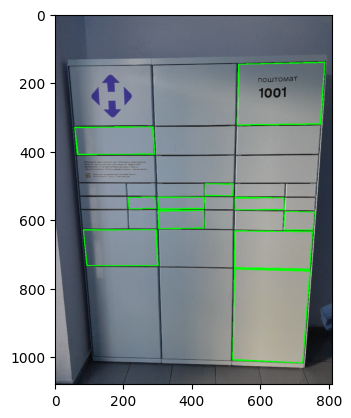

In [4]:
# Load the image 
image = cv2.imread(img_location) 
 
# Convert to grayscale 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
 
# Blur the image 
blurred = cv2.GaussianBlur(gray, (5, 5), 0) 
 
# Detect edges 
edges = cv2.Canny(blurred, 50, 150) 
 
# Find contours 
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
 
# Filter contours 
rects = [] 
for contour in contours: 
    # Approximate the contour to a polygon 
    polygon = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True) 
     
    # Check if the polygon has 4 sides and the aspect ratio is close to 1 
    if len(polygon) == 4 and abs(1 - cv2.contourArea(polygon) / (cv2.boundingRect(polygon)[2] * cv2.boundingRect(polygon)[3])) < 0.1: 
        rects.append(polygon) 
 
# Draw rectangles 
for rect in rects: 
    cv2.drawContours(image, [rect], 0, (0, 255, 0), 2) 
 
# Show the result 
plt.imshow(image)
plt.show()

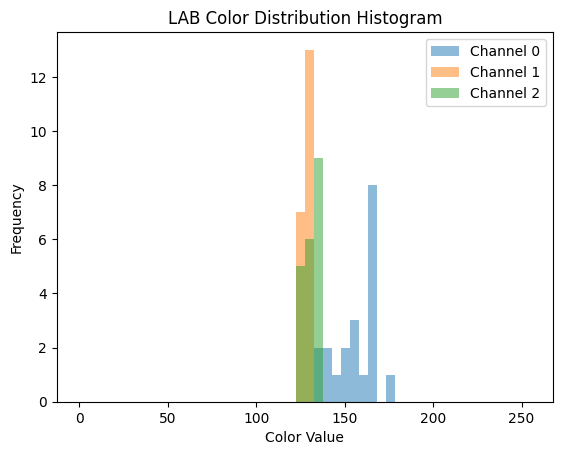

In [7]:

# Load the image
image = cv2.imread(img_location)

# Convert to LAB color space
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# Convert to grayscale for edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blur the image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Detect edges
edges = cv2.Canny(blurred, 50, 150)

# Find contours
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours
rects = []
colors = []  # List to store mean color values for each rectangle

for contour in contours:
    # Approximate the contour to a polygon
    polygon = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)

    # Check if the polygon has 4 sides and the aspect ratio is close to 1
    if len(polygon) == 4 and abs(1 - cv2.contourArea(polygon) / (cv2.boundingRect(polygon)[2] * cv2.boundingRect(polygon)[3])) < 0.1:
        rects.append(polygon)

# Extract color distribution from each rectangle
for rect in rects:
    # Get the bounding box coordinates of the rectangle
    x, y, w, h = cv2.boundingRect(rect)

    # Exclude the green rectangles
    if np.array_equal(image[y, x], [0, 255, 0]):
        continue

    # Crop the region of interest (ROI) from the LAB image
    roi_lab = lab_image[y:y + h, x:x + w]

    # Calculate the mean color values in the LAB space
    mean_color_lab = cv2.mean(roi_lab)[:3]  # Extract LAB color values
    colors.append(mean_color_lab)

# Convert the list of LAB color values to a NumPy array
colors_array_lab = np.array(colors)

# Display histogram for each LAB channel
for i in range(3):  # Loop over LAB channels
    plt.hist(colors_array_lab[:, i], bins=50, range=(0, 255), alpha=0.5, label=f'Channel {i}')

plt.xlabel('Color Value')
plt.ylabel('Frequency')
plt.legend()
plt.title('LAB Color Distribution Histogram')
plt.show()


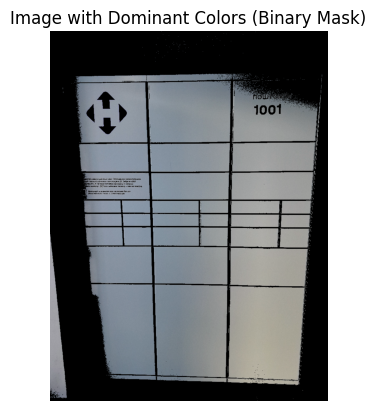

In [75]:
# Load the image
image = cv2.imread(img_location)

# Convert to LAB color space
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# Convert to grayscale for edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blur the image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Detect edges
edges = cv2.Canny(blurred, 50, 150)

# Find contours
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours
rects = []
colors = []  # List to store mean color values for each rectangle

for contour in contours:
    # Approximate the contour to a polygon
    polygon = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)

    # Check if the polygon has 4 sides and the aspect ratio is close to 1
    if len(polygon) == 4 and abs(1 - cv2.contourArea(polygon) / (cv2.boundingRect(polygon)[2] * cv2.boundingRect(polygon)[3])) < 0.1:
        rects.append(polygon)

# Extract color distribution from each rectangle
for rect in rects:
    # Get the bounding box coordinates of the rectangle
    x, y, w, h = cv2.boundingRect(rect)

    # Exclude the green rectangles
    if np.array_equal(image[y, x], [0, 255, 0]):
        continue

    # Crop the region of interest (ROI) from the LAB image
    roi_lab = lab_image[y:y + h, x:x + w]

    # Calculate the mean color values in the LAB space
    mean_color_lab = cv2.mean(roi_lab)[:3]  # Extract LAB color values
    colors.append(mean_color_lab)

# Convert the list of LAB color values to a NumPy array
colors_array_lab = np.array(colors)

# Find the dominant color
dominant_color = np.mean(colors_array_lab, axis=0)

# Create a binary mask for non-dominant colors
tolerance = 30  # Tolerance for color difference
binary_mask = np.all(np.abs(lab_image - dominant_color) < tolerance, axis=-1)

# Apply the binary mask to the original image
result_image = image.copy()
result_image[~binary_mask] = [0, 0, 0]  # Set non-dominant colors to black

# Display the result
plt.imshow(result_image)
plt.title('Image with Dominant Colors (Binary Mask)')
plt.axis('off')
plt.show()

C:\Users\Tymof\AppData\Local\Temp\ipykernel_12032\458824849.py:69: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(cv2.boxPoints(min_area_rect))


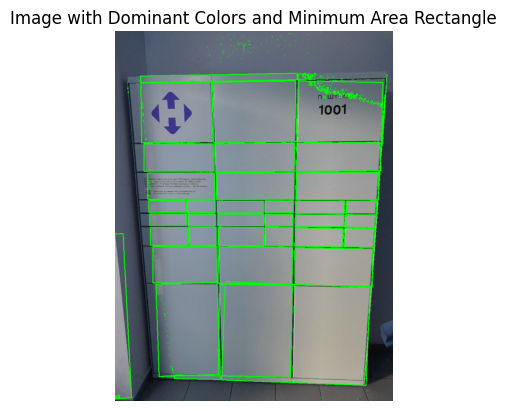

In [35]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image = cv2.imread(img_location)

# Convert to LAB color space
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# Convert to grayscale for edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blur the image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Detect edges
edges = cv2.Canny(blurred, 50, 150)

# Find contours
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours
rects = []
colors = []  # List to store mean color values for each rectangle

for contour in contours:
    # Approximate the contour to a polygon
    polygon = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)

    # Check if the polygon has 4 sides and the aspect ratio is close to 1
    if len(polygon) == 4 and abs(1 - cv2.contourArea(polygon) / (cv2.boundingRect(polygon)[2] * cv2.boundingRect(polygon)[3])) < 0.1:
        rects.append(polygon)

# Extract color distribution from each rectangle
for rect in rects:
    # Get the bounding box coordinates of the rectangle
    x, y, w, h = cv2.boundingRect(rect)

    # Exclude the green rectangles
    if np.array_equal(image[y, x], [0, 255, 0]):
        continue

    # Crop the region of interest (ROI) from the LAB image
    roi_lab = lab_image[y:y + h, x:x + w]

    # Calculate the mean color values in the LAB space
    mean_color_lab = cv2.mean(roi_lab)[:3]  # Extract LAB color values
    colors.append(mean_color_lab)

# Convert the list of LAB color values to a NumPy array
colors_array_lab = np.array(colors)

# Find the dominant color
dominant_color = np.mean(colors_array_lab, axis=0)

# Create a binary mask for non-dominant colors
tolerance = 30  # Tolerance for color difference
binary_mask = np.all(np.abs(lab_image - dominant_color) < tolerance, axis=-1)

# Find contours in the binary mask
contours, hierarchy = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the minimum area rectangle for each contour
for contour in contours:
    min_area_rect = cv2.minAreaRect(contour)

    # Convert the rectangle parameters to integers
    box = np.int0(cv2.boxPoints(min_area_rect))

    # Draw the rectangle on the original image
    cv2.drawContours(image, [box], 0, (0, 255, 0), 2)

# Display the result
plt.imshow(image)
plt.title('Image with Dominant Colors and Minimum Area Rectangle')
plt.axis('off')
plt.show()


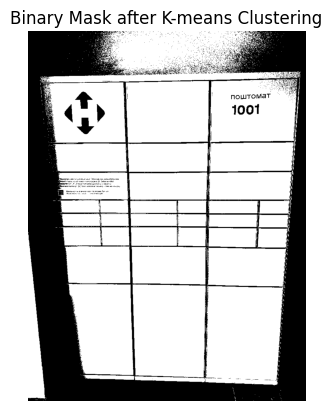

In [26]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image = cv2.imread(img_location)

# Convert to LAB color space
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# Convert to grayscale for edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blur the image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Detect edges
edges = cv2.Canny(blurred, 50, 150)

# Find contours
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours
rects = []
colors = []  # List to store mean color values for each rectangle

for contour in contours:
    # Approximate the contour to a polygon
    polygon = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)

    # Check if the polygon has 4 sides and the aspect ratio is close to 1
    if len(polygon) == 4 and abs(1 - cv2.contourArea(polygon) / (cv2.boundingRect(polygon)[2] * cv2.boundingRect(polygon)[3])) < 0.1:
        rects.append(polygon)

# Extract color distribution from each rectangle
for rect in rects:
    # Get the bounding box coordinates of the rectangle
    x, y, w, h = cv2.boundingRect(rect)

    # Exclude the green rectangles
    if np.array_equal(image[y, x], [0, 255, 0]):
        continue

    # Crop the region of interest (ROI) from the LAB image
    roi_lab = lab_image[y:y + h, x:x + w]

    # Calculate the mean color values in the LAB space
    mean_color_lab = cv2.mean(roi_lab)[:3]  # Extract LAB color values
    colors.append(mean_color_lab)

# Convert the list of LAB color values to a NumPy array
colors_array_lab = np.array(colors)

# Create binary masks for each rectangle based on dominant color ranges
binary_masks = []
for color_lab in colors_array_lab:
    lower_bound = np.maximum(color_lab - 20, [0, 0, 0])
    upper_bound = np.minimum(color_lab + 20, [255, 255, 255])
    binary_mask = cv2.inRange(lab_image, lower_bound, upper_bound)
    binary_masks.append(binary_mask)

# Combine binary masks into one
final_binary_mask = sum(binary_masks)

# Apply k-means clustering to the binary mask
num_clusters = 2  # You can adjust the number of clusters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(final_binary_mask.flatten().astype(np.float32).reshape(-1, 1), num_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Find the label with the most pixels
dominant_label = np.argmax(np.bincount(labels.flatten()))

# Create a binary mask for the dominant cluster
cluster_mask = (labels == dominant_label).reshape(final_binary_mask.shape)

# Display the result
plt.imshow(cluster_mask, cmap='gray')
plt.title('Binary Mask after K-means Clustering')
plt.axis('off')
plt.show()


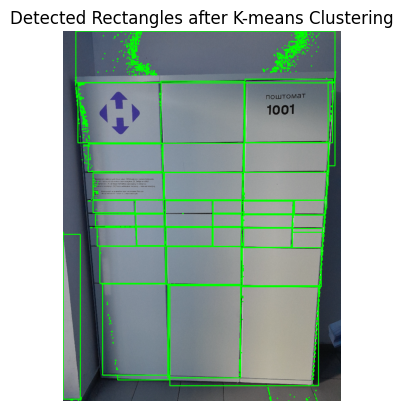

In [27]:
# Load the image
image = cv2.imread(img_location)

# Convert to LAB color space
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# Convert to grayscale for edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blur the image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Detect edges
edges = cv2.Canny(blurred, 50, 150)

# Find contours
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours
rects = []
colors = []  # List to store mean color values for each rectangle

for contour in contours:
    # Approximate the contour to a polygon
    polygon = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)

    # Check if the polygon has 4 sides and the aspect ratio is close to 1
    if len(polygon) == 4 and abs(1 - cv2.contourArea(polygon) / (cv2.boundingRect(polygon)[2] * cv2.boundingRect(polygon)[3])) < 0.1:
        rects.append(polygon)

# Extract color distribution from each rectangle
for rect in rects:
    # Get the bounding box coordinates of the rectangle
    x, y, w, h = cv2.boundingRect(rect)

    # Exclude the green rectangles
    if np.array_equal(image[y, x], [0, 255, 0]):
        continue

    # Crop the region of interest (ROI) from the LAB image
    roi_lab = lab_image[y:y + h, x:x + w]

    # Calculate the mean color values in the LAB space
    mean_color_lab = cv2.mean(roi_lab)[:3]  # Extract LAB color values
    colors.append(mean_color_lab)

# Convert the list of LAB color values to a NumPy array
colors_array_lab = np.array(colors)

# Create binary masks for each rectangle based on dominant color ranges
binary_masks = []
for color_lab in colors_array_lab:
    lower_bound = np.maximum(color_lab - 20, [0, 0, 0])
    upper_bound = np.minimum(color_lab + 20, [255, 255, 255])
    binary_mask = cv2.inRange(lab_image, lower_bound, upper_bound)
    binary_masks.append(binary_mask)

# Combine binary masks into one
final_binary_mask = sum(binary_masks)

# Apply k-means clustering to the binary mask
num_clusters = 2  # You can adjust the number of clusters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(final_binary_mask.flatten().astype(np.float32).reshape(-1, 1), num_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Find the label with the most pixels
dominant_label = np.argmax(np.bincount(labels.flatten()))

# Create a binary mask for the dominant cluster
cluster_mask = (labels == dominant_label).reshape(final_binary_mask.shape)

# Find contours in the binary mask
contours, hierarchy = cv2.findContours(cluster_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw rectangles around detected objects
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the result
plt.imshow(image)
plt.title('Detected Rectangles after K-means Clustering')
plt.axis('off')
plt.show()

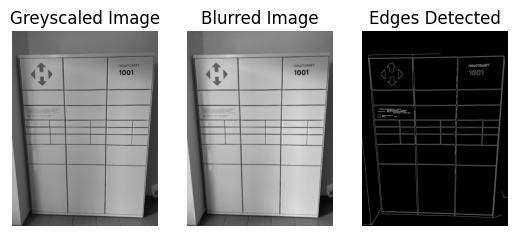

In [77]:
import cv2
import matplotlib.pyplot as plt

# Load the image 
image = cv2.imread(img_location) 
 
# Convert to grayscale 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

# Blur the image 
blurred = cv2.GaussianBlur(gray, (5, 5), 0) 

# Detect edges 
edges = cv2.Canny(blurred, 50, 150) 

# Display the greyscaled image
plt.subplot(131)
plt.imshow(gray, cmap='gray')
plt.title('Greyscaled Image')
plt.axis('off')

# Display the blurred image
plt.subplot(132)
plt.imshow(blurred, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')

# Display the edges
plt.subplot(133)
plt.imshow(edges, cmap='gray')
plt.title('Edges Detected')
plt.axis('off')

plt.show()


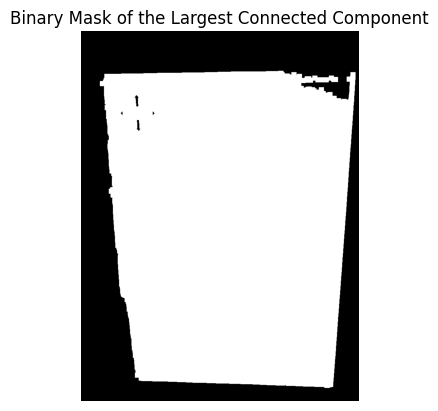

In [102]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image = cv2.imread(img_location)

# Convert to LAB color space
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# Convert to grayscale for edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blur the image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Detect edges
edges = cv2.Canny(blurred, 50, 150)

# Create a binary mask for non-dominant colors
tolerance = 30  # Tolerance for color difference
binary_mask = np.all(np.abs(lab_image - dominant_color) < tolerance, axis=-1)

# Apply morphological dilation to connect nearby regions
kernel = np.ones((15, 15), np.uint8)  # Adjust the kernel size as needed
connected_mask = cv2.dilate(binary_mask.astype(np.uint8), kernel, iterations=1)

# Use connected components to label objects in the connected mask
_, labels, stats, _ = cv2.connectedComponentsWithStats(connected_mask)

# Find the label of the largest connected component
largest_component_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1

# Create a binary mask for the largest connected component
largest_component_mask = (labels == largest_component_label).astype(np.uint8)

# Display the result binary mask
plt.imshow(largest_component_mask, cmap='gray')
plt.title('Binary Mask of the Largest Connected Component')
plt.axis('off')
plt.show()


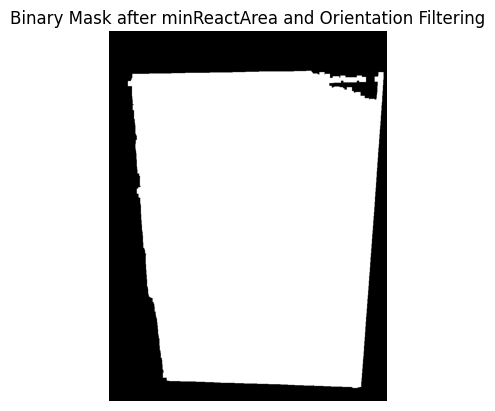

In [104]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def minReactArea(contour):
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    return cv2.contourArea(contour) / cv2.contourArea(box)

# Load the image
image = cv2.imread(img_location)

# Convert to LAB color space
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# Convert to grayscale for edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blur the image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Detect edges
edges = cv2.Canny(blurred, 50, 150)

# Create a binary mask for non-dominant colors
tolerance = 30  # Tolerance for color difference
binary_mask = np.all(np.abs(lab_image - dominant_color) < tolerance, axis=-1)

# Apply morphological dilation to connect nearby regions
kernel = np.ones((15, 15), np.uint8)  # Adjust the kernel size as needed
connected_mask = cv2.dilate(binary_mask.astype(np.uint8), kernel, iterations=1)

# Use connected components to label objects in the connected mask
_, labels, stats, _ = cv2.connectedComponentsWithStats(connected_mask)

# Find the label of the largest connected component
largest_component_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1

# Create a binary mask for the largest connected component
largest_component_mask = (labels == largest_component_label).astype(np.uint8)

# Find contours in the binary mask
contours, _ = cv2.findContours(largest_component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours based on minReactArea and orientation
min_react_area_threshold = 0.1  # Adjust this value based on your requirements
filtered_contours = []

for contour in contours:
    if minReactArea(contour) > min_react_area_threshold:
        rect = cv2.minAreaRect(contour)
        _, _, angle = rect
        if angle < -45:
            angle += 90
        if angle > 0:
            filtered_contours.append(contour)

# Create a binary mask for the filtered contours
filtered_mask = np.zeros_like(largest_component_mask)
cv2.drawContours(filtered_mask, filtered_contours, -1, 1, thickness=cv2.FILLED)

# Display the result binary mask
plt.imshow(filtered_mask, cmap='gray')
plt.title('Binary Mask after minReactArea and Orientation Filtering')
plt.axis('off')
plt.show()


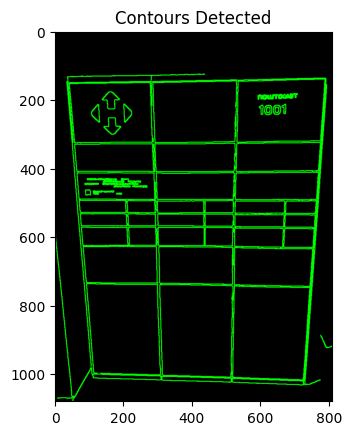

In [79]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the image 
image = cv2.imread(img_location) 
 
# Convert to grayscale 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

# Blur the image 
blurred = cv2.GaussianBlur(gray, (5, 5), 0) 

# Detect edges 
edges = cv2.Canny(blurred, 50, 150) 

# Find contours 
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 

# Draw all contours on a blank canvas
canvas = np.zeros_like(image)
cv2.drawContours(canvas, contours, -1, (0, 255, 0), 2)

# Show the contours on the blank canvas
plt.imshow(canvas)
plt.title('Contours Detected')
plt.show()


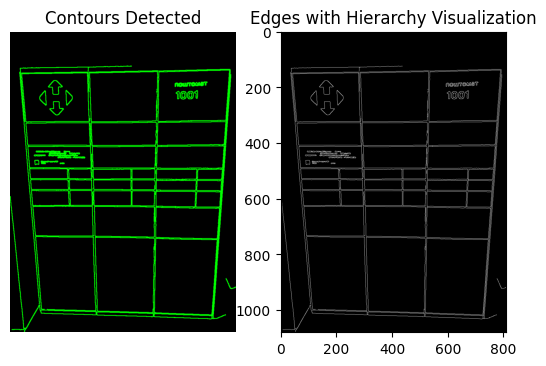

In [80]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the image 
image = cv2.imread(img_location) 
 
# Convert to grayscale 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

# Blur the image 
blurred = cv2.GaussianBlur(gray, (5, 5), 0) 

# Detect edges 
edges = cv2.Canny(blurred, 50, 150) 

# Find contours 
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 

# Draw all contours on a blank canvas
canvas = np.zeros_like(image)
cv2.drawContours(canvas, contours, -1, (0, 255, 0), 2)

# Show the contours on the blank canvas
plt.subplot(121)
plt.imshow(canvas)
plt.title('Contours Detected')
plt.axis('off')

# Display the hierarchy
plt.subplot(122)
plt.imshow(edges, cmap='gray')
plt.title('Edges with Hierarchy Visualization')

# Plot hierarchy lines
for i, h in enumerate(hierarchy[0]):
    if h[3] != -1:
        cv2.line(edges, tuple(contours[i][0][0]), tuple(contours[h[3]][0][0]), 128, 1)

plt.show()
